# Data Cleaning Pipeline

In [1]:
# Only need to assign the two values below first, then run all
watershed = 'Georgia'
main_str = 'Altamaha'

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import copy
from pandas.plotting import register_matplotlib_converters
from sklearn import linear_model
from sklearn.metrics import r2_score
import copy
import os
import matplotlib.backends.backend_pdf
lm = linear_model.LinearRegression()
np.random.seed(50)
plt.rcParams.update({'figure.max_open_warning': 0})
register_matplotlib_converters()
os.getcwd()

'/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/11-Georgia/DailyData'

In [3]:
# local functions
import sys
sys.path.insert(1, '/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/Functions')

from Abnormal_data_values_control import outvalues,threC
from Source_QC_functions_L import interpolateQC, regressorFunc, funcClimateCatalog, AssembleClimateCatalog

In [4]:
# Read the original data table
table = pd.read_csv('1_'+watershed+'_Download_Aggregation_Daily.csv',header = 0,index_col = 'DateTime',
                    parse_dates = True, infer_datetime_format = True,low_memory=False)
display(table.head(2))
display(table.tail(2))

Altamaha_Discharge  Sapelo_Precipitation  \
DateTime                                               
1957-05-01            283000.0                  7.37   
1957-05-02            272246.0                  2.29   

            MarshLanding_Precipitation  Sapelo_AirTemperature  \
DateTime                                                        
1957-05-01                         NaN                   22.8   
1957-05-02                         NaN                   23.9   

            MarshLanding_AirTemperature  MarshLanding_SolarRadiation  \
DateTime                                                               
1957-05-01                          NaN                          NaN   
1957-05-02                          NaN                          NaN   

            MarshLanding_RelativeHumidity  MarshLanding_WindDirection  \
DateTime                                                                
1957-05-01                            NaN                         NaN   
1957-05-02                            NaN                         NaN   

            MarshLanding_WindSpeed  
DateTime                            
1957-05-01                     NaN  
1957-05-02                     NaN

Altamaha_Discharge  Sapelo_Precipitation  \
DateTime                                               
2017-12-30            190459.0                   NaN   
2017-12-31                 NaN                   NaN   

            MarshLanding_Precipitation  Sapelo_AirTemperature  \
DateTime                                                        
2017-12-30                       0.000                    NaN   
2017-12-31                       0.254                    NaN   

            MarshLanding_AirTemperature  MarshLanding_SolarRadiation  \
DateTime                                                               
2017-12-30                       6.4008                       78.267   
2017-12-31                       7.5156                       28.933   

            MarshLanding_RelativeHumidity  MarshLanding_WindDirection  \
DateTime                                                                
2017-12-30                        83.6521                    329.4237   
2017-12-31                        82.1365                    308.9727   

            MarshLanding_WindSpeed  
DateTime                            
2017-12-30                   2.437  
2017-12-31                   2.755

In [5]:
# Check all the station names
all_stations = table.columns.str.extract(r'([^_]+)')[0]
print('All stations names: ', all_stations.unique())
print ('  ')
nameStrflwStation=[]
nameHydrMetStation=[]
for i in np.arange(len(table.columns)):
    if table.columns[i][-9:]=='Discharge':  ### 
        if not all_stations[i] in nameStrflwStation:
            nameStrflwStation.append(all_stations[i]) ### 
    else:
        if not all_stations[i] in nameHydrMetStation:
            nameHydrMetStation.append(all_stations[i])  ### 

print('Discharge stations :',nameStrflwStation)
print('  ')
print('Meteorology stations:',nameHydrMetStation)                  

All stations names:  ['Altamaha' 'Sapelo' 'MarshLanding']
  
Discharge stations : ['Altamaha']
  
Meteorology stations: ['Sapelo', 'MarshLanding']


In [6]:
for i in table.columns:
    if i.split('_')[0] == main_str :
        print(i)

Altamaha_Discharge


In [7]:
len(nameHydrMetStation)

2

#  1. Trim the original table

In [8]:
# Trim the data and let the table start with first non nan value, end with last non nan value
# Identify the first non nan value in each column as the starting date.
# Identify the last non nan value in each column as the ending date.

t = table.notna() 
t = ~np.isnan(table)
col = len(t.columns)
b = np.zeros([table.shape[1]])
c = np.array([table.shape[0]] * table.shape[1])

for i in range(col):
    if any(t.iloc[:,i]): # Since some are empty
        b[i] = list(np.where(t.iloc[:,i] == True))[0][0] # the first non nan value location
        c[i] = list(np.where(t.iloc[:,i] == True))[0][-1] # the last non nan value location
        
st_tab = b.min()
table1 = table.iloc[int(b.min()):int(c.max()) + 1,:] 

# Display the trimmed table
display(table1.head(2))
display(table1.tail(2))
print('trimmed row number is ', int(table.shape[0] -  table1.shape[0]))

Altamaha_Discharge  Sapelo_Precipitation  \
DateTime                                               
1957-05-01            283000.0                  7.37   
1957-05-02            272246.0                  2.29   

            MarshLanding_Precipitation  Sapelo_AirTemperature  \
DateTime                                                        
1957-05-01                         NaN                   22.8   
1957-05-02                         NaN                   23.9   

            MarshLanding_AirTemperature  MarshLanding_SolarRadiation  \
DateTime                                                               
1957-05-01                          NaN                          NaN   
1957-05-02                          NaN                          NaN   

            MarshLanding_RelativeHumidity  MarshLanding_WindDirection  \
DateTime                                                                
1957-05-01                            NaN                         NaN   
1957-05-02                            NaN                         NaN   

            MarshLanding_WindSpeed  
DateTime                            
1957-05-01                     NaN  
1957-05-02                     NaN

Altamaha_Discharge  Sapelo_Precipitation  \
DateTime                                               
2017-12-30            190459.0                   NaN   
2017-12-31                 NaN                   NaN   

            MarshLanding_Precipitation  Sapelo_AirTemperature  \
DateTime                                                        
2017-12-30                       0.000                    NaN   
2017-12-31                       0.254                    NaN   

            MarshLanding_AirTemperature  MarshLanding_SolarRadiation  \
DateTime                                                               
2017-12-30                       6.4008                       78.267   
2017-12-31                       7.5156                       28.933   

            MarshLanding_RelativeHumidity  MarshLanding_WindDirection  \
DateTime                                                                
2017-12-30                        83.6521                    329.4237   
2017-12-31                        82.1365                    308.9727   

            MarshLanding_WindSpeed  
DateTime                            
2017-12-30                   2.437  
2017-12-31                   2.755

trimmed row number is  0


### Drop columns without data

In [9]:
tt = copy.deepcopy(table1)
for dd in np.arange(len(tt.columns)):
    if all(pd.isna(tt.iloc[:,dd])):
        print('The empty column is ', dd,tt.columns[dd])
        table1.drop(columns = tt.columns[dd], axis=1, inplace = True)

var_number = table1.shape[1] 

if table1.shape[1]  == table.shape[1] :
    print('There are no empty columns!')

There are no empty columns!


### Save the original discharge table seperately

In [10]:
DischargeTable = pd.DataFrame(index = table1.index)
for i in np.arange(len(nameStrflwStation)):
    DischargeTable[nameStrflwStation[i]+'_Discharge'] = table1.loc[:,nameStrflwStation[i]+'_Discharge']

DischargeTable.to_csv('1_'+ watershed + '_DischargeTable.csv')

# 2. Data filling method: Interpolation

 
0 Altamaha_Discharge :No missing data!
1 Sapelo_Precipitation index of interpolated length = 158
No filled values are out of original data range
 
2 MarshLanding_Precipitation index of interpolated length = 24
No filled values are out of original data range
 
3 Sapelo_AirTemperature index of interpolated length = 435
No filled values are out of original data range
 
4 MarshLanding_AirTemperature index of interpolated length = 41
No filled values are out of original data range
 
5 MarshLanding_SolarRadiation index of interpolated length = 68
No filled values are out of original data range
 
6 MarshLanding_RelativeHumidity index of interpolated length = 39
No filled values are out of original data range
 
7 MarshLanding_WindDirection index of interpolated length = 38
No filled values are out of original data range
 
8 MarshLanding_WindSpeed index of interpolated length = 38
No filled values are out of original data range
 


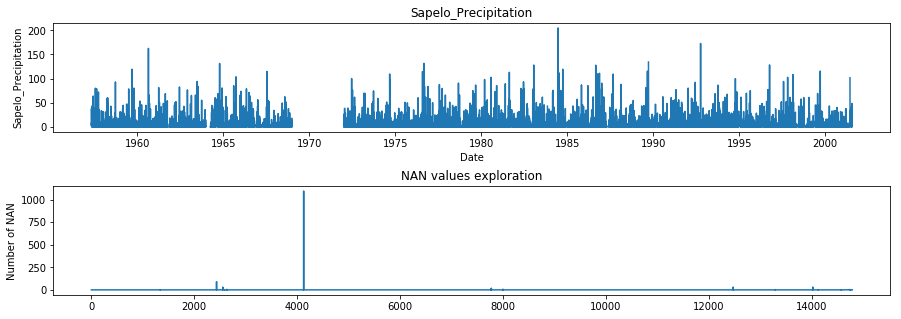

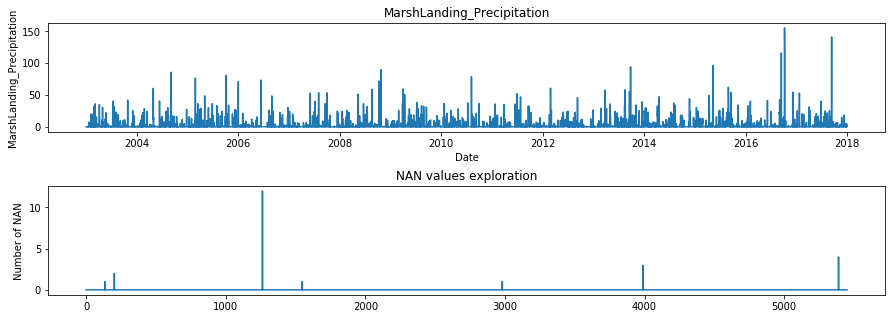

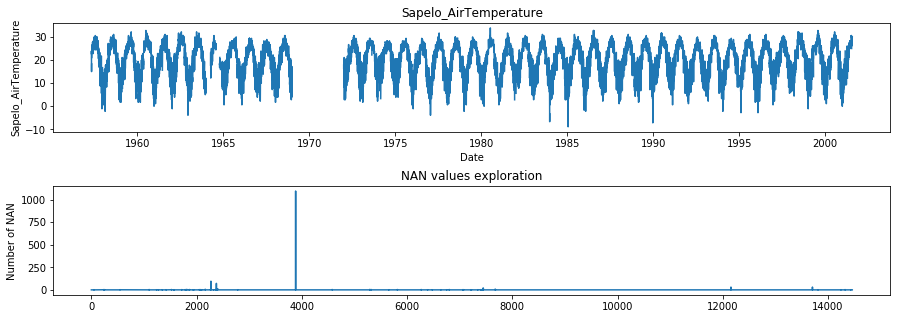

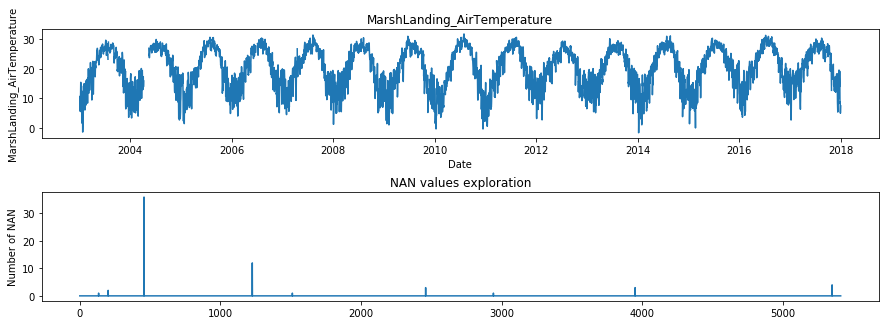

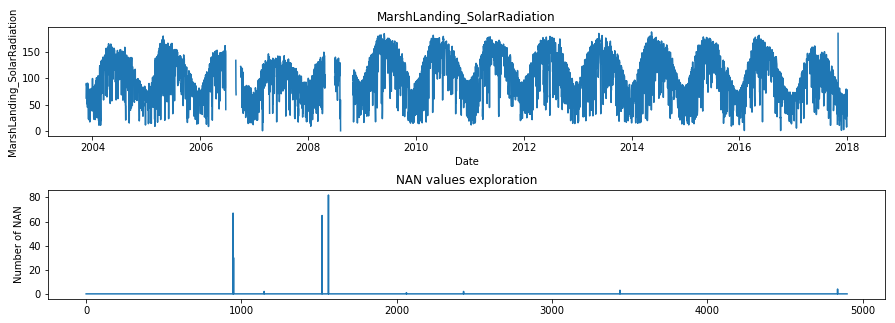

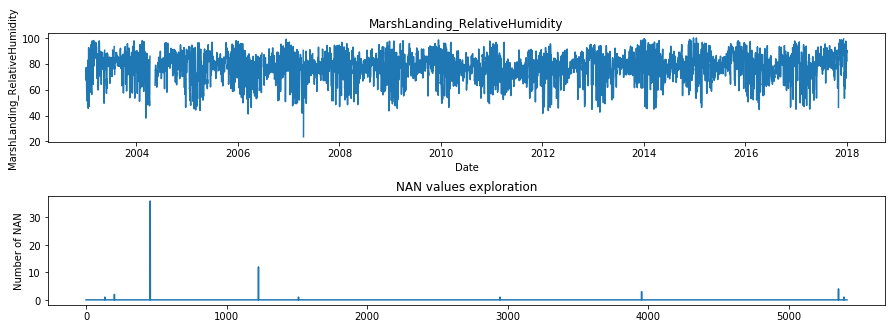

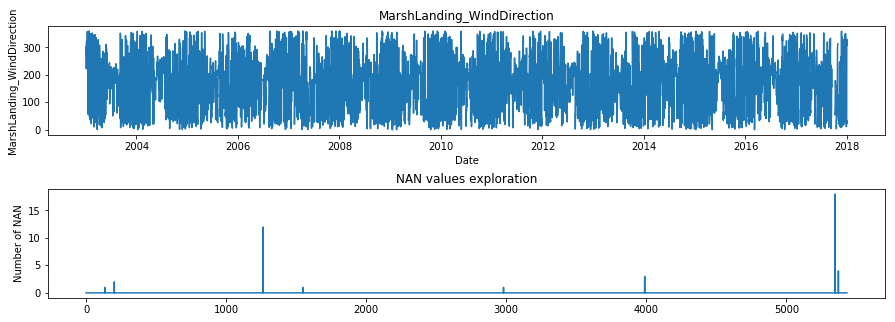

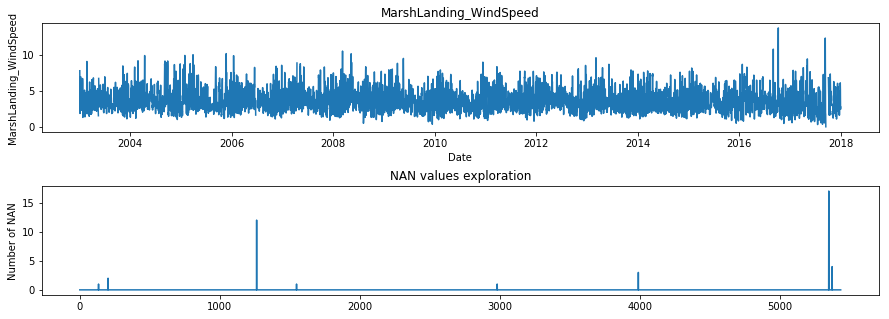

In [11]:
# =====================================
# First data exploration with plots.
# Check the number of Missing values.
# Do interpolation on the missing values positions

# table 2 will be used to be updated with interpolated values
table2=copy.deepcopy(table1) 

# a dictionary that store data record for each column
y1={} 

# Create a flag table(flag_table2) to store interpolation indicators
indexUnique=table2.index
ready_columns=pd.unique(table2.columns) 
if len(pd.unique(table2.columns))!=len(table2.columns):
    print("Duplicate columns exist!")
flag_table2=pd.DataFrame(np.nan*np.ones([len(indexUnique),len(ready_columns)]),
                 index = indexUnique, columns=ready_columns) 


for k,VarName in enumerate(ready_columns): # column of variable being processed 
    y1[k]=table2[VarName].copy(deep = True)
    ind=np.where(~np.isnan(y1[k].to_numpy())) # index where y1 has value (not NaN)
    flag_table2[VarName][ind[0]] = int(1) # set indicator 1 to original data positions
    start = ind[0][0]
    end = ind[0][-1]
    missing_index = list(set(range(start,end+1)) - set(ind[0]))
    flag_table2[VarName][missing_index] = int(0) # set indicator 0 to missing data positions
    y1[k] = y1[k][start:end+1] # trim y1   
    
    # Print out whether the column contain missing values
    dim = np.shape(ind)[1] # number of exsiting data points 
    if (dim != len(y1[k])): # there are missing data
        #===========================
        # For those columns that contain missing values:Plot the data and indicate nan values position and length
        fig1 = plt.figure(figsize=[15,5])
        sp1, sp2 = fig1.add_subplot(211), fig1.add_subplot(212)
        sp1.plot(y1[k])
        sp1.set_title(table2.columns[k])
        sp1.set_xlabel('Date')
        sp1.set_ylabel(table2.columns[k])
    
        index = np.argwhere(~np.isnan(y1[k].to_numpy())) # An array of index that the value is not nan (where data exist)
        lenNAN = (np.diff(index,axis=0)) - 1 # An array that indicate the NAN value number along data record

        pd.DataFrame(lenNAN)
        sp2.plot(lenNAN)
        sp2.set_title("NAN values exploration")
        sp2.set_ylabel('Number of NAN')
        plt.subplots_adjust(hspace=0.5)

        #===========================
        # For those columns that contain missing values: Do Interpolation 
        y2, nanR, whereINT=interpolateQC(pd.DataFrame(y1[k]),inteplimit = 7,name = VarName,k=k) # maximum interpolation length is 3! days
        # Update table 3 with interpolated values
        table2.loc[:,VarName]=y2[0] 
        
        # Update flag table with interpolation indicators 2
        flag_table2[VarName][np.reshape(whereINT[0], whereINT[0].shape[0])+start] = int(2) 
        
        # Check if the value is out of original threshold, don't forget to change flag table as well
        outvalues(table, table2, flag_table2, VarName)
        print(" ")
    else:    
        print(" ")
        print(k,VarName, ":No missing data!")

### Store the data table and the flag table after interpolation

In [12]:
flag_table2.head(2)

Altamaha_Discharge  Sapelo_Precipitation  \
DateTime                                               
1957-05-01                 1.0                   1.0   
1957-05-02                 1.0                   1.0   

            MarshLanding_Precipitation  Sapelo_AirTemperature  \
DateTime                                                        
1957-05-01                         NaN                    1.0   
1957-05-02                         NaN                    1.0   

            MarshLanding_AirTemperature  MarshLanding_SolarRadiation  \
DateTime                                                               
1957-05-01                          NaN                          NaN   
1957-05-02                          NaN                          NaN   

            MarshLanding_RelativeHumidity  MarshLanding_WindDirection  \
DateTime                                                                
1957-05-01                            NaN                         NaN   
1957-05-02                            NaN                         NaN   

            MarshLanding_WindSpeed  
DateTime                            
1957-05-01                     NaN  
1957-05-02                     NaN

In [13]:
table2.to_csv('2_' + watershed + '_Interpolation.csv', sep=',')
flag_table2.to_csv('2_' + watershed + '_Interpolation_Flag.csv', sep=',')
all(table2.columns == flag_table2.columns)

True

# 3. Data filling method: Regression (across stations)

In [14]:
# Some functions to be used
def get_ind(table,var):
    nameTab = pd.Series(table.columns)
    n_Tab = nameTab.apply(lambda x: x.split('_'))[:]
    var_stn = table.columns[n_Tab.apply(lambda x: x[1] == var)]
    range_all = np.array([np.where(~np.isnan(table[c].to_numpy()))[0] for c in var_stn])
    start = np.min([x[0] for x in range_all])
    end = np.max([x[-1] for x in range_all])
    ind = table.index[start:end+1]
    return ind 

def fromEveryStationPoolAvariable(stn_names,var,ind,stn_table_dic): 
# stn_names is names for all stns, var is a variable name, ind is the index of stn i 
# stn_table_dic is a dictionary storing data by stn, nn is an empty df
    nn = pd.DataFrame(index=ind)
    for k in np.arange(len(stn_names)): # read the station table
        tabReg2 = stn_table_dic[k] # the table for stn k
        for m in np.arange(len(tabReg2.columns)): # for each observation at stn k
             if str.find(tabReg2.columns[m],var) != -1: # stn k has observation for this variable(var)
                useful_col=tabReg2.columns[m]
                ind2=get_ind(tabReg2,var)
                overlap_time=pd.Series(list(set(ind)&set(ind2)))
                if len(overlap_time)!=0: #stn i and stn k have overlapped time range for var
                    nn.loc[overlap_time,useful_col] = tabReg2.loc[overlap_time,useful_col] #get the data of this variable at stn k                
                
    return nn


def regressionAtStationForAvariable(nn,stnName,var): #stnName = stn_names[i]
    nameTab = pd.Series(nn.columns)
    n_Tab = nameTab.apply(lambda x: x.split('_'))[:]
    stnofInterest = n_Tab.apply(lambda x: x[0] == stnName) # station name is at the beigning
    colInt = np.argwhere(stnofInterest.to_numpy() == 1)  
    mesName = nn.columns # all the column names for this variable(var)   
    
    for col in colInt:
        p = np.delete(np.arange(len(mesName)), col)# get rid of the col that will be apply regression method
        tt = nn.iloc[:,np.r_[col,p]]# put the target col at the first
        regR = regressorFunc(tt,regThres=0.7)

        
        # return ind_interp
        # location where Regression happened
        #ind_interp = np.argwhere(regR != nn.iloc[:,col].to_numpy()) # this is commented out because it can't discriminate nan values
  
        # plot 
        plt.figure(figsize=[5,1])
        plt.plot(regR,color='black',label= var+' After regression')
        plt.plot(np.array(nn.iloc[:,col]), color='red', label='Raw data')        
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.title(nn.columns[col])    
        
        # Update the variable table
        nn.iloc[:,col] = regR
    return nn

### Do regression across all stations

In [15]:
# table3 will be updated with regression values
table3 = copy.deepcopy(table2)
flag_table3 = copy.deepcopy(flag_table2)

In [16]:
# Store tables into a dictionary seperated by stations, store the data after interpolation
stn_table_dic = {}
col_names = pd.Series(table2.columns)
n_tab = col_names.apply(lambda x: x.split('_'))[:]
var_names = n_tab.apply(lambda x: x[1]).unique()
stn_names = n_tab.apply(lambda x: x[0]).unique()
print('var_names:',var_names)

for i in range(len(stn_names)): # column of variable being processed
    station = stn_names[i] 
    #print(station)
    station_lst = []
    for col in col_names:
        if col.split('_')[0] == station:
            station_lst.append(col)
    #print(station_lst)
    stn_table_dic[i] = copy.deepcopy(table2[station_lst])
    
# check if the results of all station have been stored
len(stn_table_dic.keys()) == len(stn_names)

var_names: ['Discharge' 'Precipitation' 'AirTemperature' 'SolarRadiation'
 'RelativeHumidity' 'WindDirection' 'WindSpeed']


True

1 / 3 in process: Altamaha Discharge
 
No Precipitation data at station Altamaha
 
No AirTemperature data at station Altamaha
 
No SolarRadiation data at station Altamaha
 
No RelativeHumidity data at station Altamaha
 
No WindDirection data at station Altamaha
 
No WindSpeed data at station Altamaha
 
No Discharge data at station Sapelo
 
2 / 3 in process: Sapelo Precipitation


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


 
2 / 3 in process: Sapelo AirTemperature
 
No SolarRadiation data at station Sapelo
 
No RelativeHumidity data at station Sapelo
 
No WindDirection data at station Sapelo
 
No WindSpeed data at station Sapelo
 
No Discharge data at station MarshLanding
 
3 / 3 in process: MarshLanding Precipitation
 
3 / 3 in process: MarshLanding AirTemperature
 
3 / 3 in process: MarshLanding SolarRadiation
 
3 / 3 in process: MarshLanding RelativeHumidity
 
3 / 3 in process: MarshLanding WindDirection
 
3 / 3 in process: MarshLanding WindSpeed
 
CPU times: user 628 ms, sys: 21.3 ms, total: 649 ms
Wall time: 667 ms


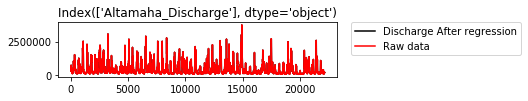

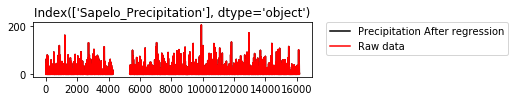

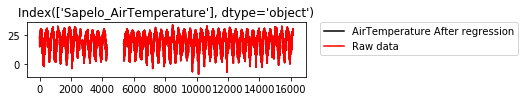

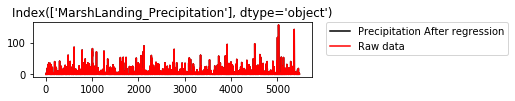

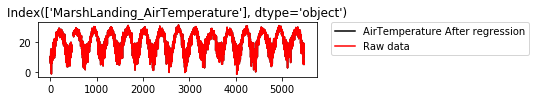

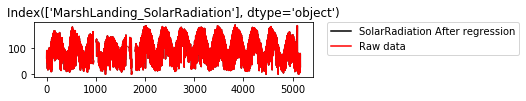

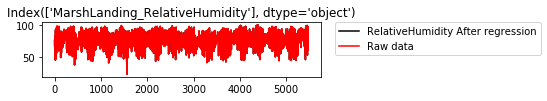

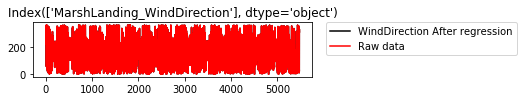

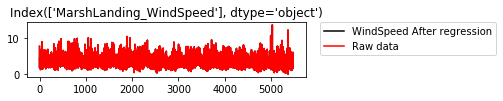

In [17]:
%%time
for i in np.arange(len(stn_names)): # Each met station
    tabReg = stn_table_dic[i]  # extract the table for station i from the dictionary
    for j in np.arange(len(var_names)): # loop across variables, not looping for discharge
        var = var_names[j] # for each meteorology variable
        if var in pd.unique(np.array([c.split('_')[1] for c in tabReg.columns])):
            ind = get_ind(tabReg,var)
            print(i+1,"/",len(stn_names),"in process:",stn_names[i],var)
            # Fill single variable from multiple stations
            nn = fromEveryStationPoolAvariable(stn_names, var, ind, stn_table_dic)
            ## nn is a df storing the all the data for the same variable(var)

            # Do regression across stations for met station i, variable j
            result = regressionAtStationForAvariable(nn, stn_names[i], var)
            regressed_cols = pd.Series(list(set(result.columns) & set(tabReg.columns)),dtype='object') # column where regression is done
            
            # Update table3 with regression results
            #print('Finishing regression on Station', stn_names[i], var) 
            for k in np.arange(len(regressed_cols)):
                rcol=regressed_cols[k]
                reg=result[rcol]
                table3.loc[reg.index[0]:reg.index[-1],rcol] = np.array(reg)
        else:
            print("No",var,"data at station",stn_names[i])
        print(' ')

In [18]:
# Write indicators of regression into flag table
for j in range(len(col_names)):
    col = col_names[j]
    for m in table3[col].index:  
        if str(table2[col][m]) == 'nan':
            if str(table3[col][m])!= 'nan':
                flag_table3[col][m] = int(3)

In [19]:
# Check the regression values and delete out of range values
for col in col_names:
    outvalues(table, table3, flag_table3, col)

No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range


In [20]:
# Store the data table and the flag table
table3.to_csv('3_'+watershed+'_Regression.csv', sep=',')
flag_table3.to_csv('3_'+watershed+'_Regression_Flag.csv', sep=',')

# 4. Data filling method: Climate Catalog

In [21]:
# Extract discharge table
DischargeTable = pd.DataFrame(index = table3.index)
for i in np.arange(len(nameStrflwStation)):
    DischargeTable[nameStrflwStation[i]+'_Discharge'] = table3.loc[:,nameStrflwStation[i]+'_Discharge']
DischargeTable.head(2)

Altamaha_Discharge
DateTime                      
1957-05-01            283000.0
1957-05-02            272246.0

In [22]:
y3 = {}
for i in np.arange(len(table3.columns)):
    col_name = table3.columns[i]
    range_y3 = np.where(~np.isnan(table3[col_name].to_numpy()))[0]
    start = range_y3[0]
    end = range_y3[-1]
    y3[i] = table3[col_name][start:end+1]
AnT = funcClimateCatalog(table3, y3, 270, watershed, 0.7) # divide the data by year
table4,whereClimateCat = AssembleClimateCatalog(AnT, y3, table3, watershed)

0 Altamaha_Discharge 0
1 Sapelo_Precipitation 132
2 MarshLanding_Precipitation 0
3 Sapelo_AirTemperature 43
4 MarshLanding_AirTemperature 22
5 MarshLanding_SolarRadiation 69
6 MarshLanding_RelativeHumidity 22
7 MarshLanding_WindDirection 4
8 MarshLanding_WindSpeed 3


In [23]:
# Write indicators of ClimateCatalog into flag table4
flag_table4 = copy.deepcopy(flag_table3)
for j in range(len(col_names)):
    col = col_names[j]
    for m in table4[col].index:  
        if str(table3[col][m]) == 'nan':
            if str(table4[col][m])!= 'nan':
                flag_table4[col][m] = int(4)

In [24]:
# Check the regression values and delete out of range values
for col in col_names:
    outvalues(table, table4, flag_table4, col)

No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range


In [25]:
# Store the data table and the flag table
table4.to_csv('4_'+watershed+'_ClimateCatalog.csv', sep=',')
flag_table4.to_csv('4_'+watershed+'_ClimateCatalog_Flag.csv', sep=',')

In [26]:
table4.head()

Altamaha_Discharge  Sapelo_Precipitation  \
DateTime                                               
1957-05-01            283000.0                  7.37   
1957-05-02            272246.0                  2.29   
1957-05-03            272246.0                 37.59   
1957-05-04            288660.0                 33.78   
1957-05-05            288660.0                  0.51   

            MarshLanding_Precipitation  Sapelo_AirTemperature  \
DateTime                                                        
1957-05-01                         NaN                   22.8   
1957-05-02                         NaN                   23.9   
1957-05-03                         NaN                   21.7   
1957-05-04                         NaN                   18.9   
1957-05-05                         NaN                   15.0   

            MarshLanding_AirTemperature  MarshLanding_SolarRadiation  \
DateTime                                                               
1957-05-01                          NaN                          NaN   
1957-05-02                          NaN                          NaN   
1957-05-03                          NaN                          NaN   
1957-05-04                          NaN                          NaN   
1957-05-05                          NaN                          NaN   

            MarshLanding_RelativeHumidity  MarshLanding_WindDirection  \
DateTime                                                                
1957-05-01                            NaN                         NaN   
1957-05-02                            NaN                         NaN   
1957-05-03                            NaN                         NaN   
1957-05-04                            NaN                         NaN   
1957-05-05                            NaN                         NaN   

            MarshLanding_WindSpeed  
DateTime                            
1957-05-01                     NaN  
1957-05-02                     NaN  
1957-05-03                     NaN  
1957-05-04                     NaN  
1957-05-05                     NaN

In [27]:
flag_table4.head()

Altamaha_Discharge  Sapelo_Precipitation  \
DateTime                                               
1957-05-01                 1.0                   1.0   
1957-05-02                 1.0                   1.0   
1957-05-03                 1.0                   1.0   
1957-05-04                 1.0                   1.0   
1957-05-05                 1.0                   1.0   

            MarshLanding_Precipitation  Sapelo_AirTemperature  \
DateTime                                                        
1957-05-01                         NaN                    1.0   
1957-05-02                         NaN                    1.0   
1957-05-03                         NaN                    1.0   
1957-05-04                         NaN                    1.0   
1957-05-05                         NaN                    1.0   

            MarshLanding_AirTemperature  MarshLanding_SolarRadiation  \
DateTime                                                               
1957-05-01                          NaN                          NaN   
1957-05-02                          NaN                          NaN   
1957-05-03                          NaN                          NaN   
1957-05-04                          NaN                          NaN   
1957-05-05                          NaN                          NaN   

            MarshLanding_RelativeHumidity  MarshLanding_WindDirection  \
DateTime                                                                
1957-05-01                            NaN                         NaN   
1957-05-02                            NaN                         NaN   
1957-05-03                            NaN                         NaN   
1957-05-04                            NaN                         NaN   
1957-05-05                            NaN                         NaN   

            MarshLanding_WindSpeed  
DateTime                            
1957-05-01                     NaN  
1957-05-02                     NaN  
1957-05-03                     NaN  
1957-05-04                     NaN  
1957-05-05                     NaN

In [28]:
table4.shape

(22160, 9)

In [29]:
flag_table4.shape

(22160, 9)